In [1]:
import access
from access import Access, weights, Datasets
import geopandas as gpd
import gzip
import os
import pandas as pd
import pathlib
import subprocess
from typing import List, Tuple, Union

/data/keeling/a/michels9/anaconda3/envs/tcm/lib/python3.8/site-packages/geopandas/_compat.py:124: UserWarning: The Shapely GEOS version (3.11.3-CAPI-1.17.3) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
/data/cigi/scratch/michels9/tmp/ipykernel_19974/3582021189.py:3: DeprecationWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas still uses PyGEOS by default. However, starting with version 0.14, the default will switch to Shapely. To force to use Shapely 2.0 now, you can either uninstall PyGEOS or set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In the next release, GeoPandas will switch to using Shapely by default, even if PyGEOS is installed. If you only have PyGEOS installed to get speed-ups, this switch should b

In [2]:
def get_git_revision_hash() -> str:
    # from here: https://stackoverflow.com/questions/14989858/get-the-current-git-hash-in-a-python-script 
    return subprocess.check_output(['git', 'rev-parse', 'HEAD']).decode('ascii').strip()

In [3]:
## debugging information
print("\n**Debugging information**\n")
print(f"pysal/access version: {access.__version__}")
print(f"Git commit hash {get_git_revision_hash()}")
print("\n**End debugging info**\n\n")


**Debugging information**

pysal/access version: 1.1.9
Git commit hash 335d6735904846bd1cab8f2078fd09159f9f2575

**End debugging info**




## TODO

* allow for multi-select for methods
* input data for population
* allow supply data file to be named anything
* allow supply data file to be any data type
* input data for travel times

In [4]:
# general CyberGIS-Compute variables that will be useful
RESULT_FOLDER = os.getenv('result_folder')
# DATA_FOLDER = os.getenv('data_folder')

# get the appropriate variables, these will be passed by CyberGIS-Compute
MOBILITY_MODE = os.getenv('param_mobility_mode')
POPULATION_TYPE = os.getenv('param_population_type')
MAX_TRAVEL_TIME = os.getenv('param_max_travel_time')
ACCESS_MEASURE = os.getenv('param_access_measure')
# SUPPLY_FILENAME = os.getenv('param_supply_filename')

# # supply data
# SUPPLY_CAPACITY = os.getenv('param_supply_capacity')
# SUPPLY_LATLON_OR_ID = os.getenv('param_supply_latlon_or_id')
# SUPPLY_LAT = os.getenv('param_supply_lat')
# SUPPLY_LON = os.getenv('param_supply_lon')
# SUPPLY_ID = os.getenv('param_supply_id')

In [5]:
# for testing purposes
# general CyberGIS-Compute variables that will be useful
# RESULT_FOLDER = "result"
DATA_FOLDER = "/job/herop_access_data"  # this is mounted into the container, need more complex logic later to allow for uploaded data

# get the appropriate variables, these will be passed by CyberGIS-Compute
# MOBILITY_MODE = "DRIVING"
# POPULATION_TYPE = "TRACT"
# MAX_TRAVEL_TIME = "30"
# ACCESS_MEASURE = "ALL"

# supply data
SUPPLY_FILENAME = "chi_doc_pysal.csv"  # assume CSV for now
SUPPLY_CAPACITY = "doc"
SUPPLY_LATLON_OR_ID = "ID"  # binary option between LATLON or ID
SUPPLY_LAT = ""
SUPPLY_LON = ""
SUPPLY_ID = "geoid"

In [ ]:
# geography data
geo_join_col = "GEOID" if POPULATION_TYPE == 'TRACT' else "GEOID10"

# population data
population_join_col = 'FIPS'  # TODO: is this always FIPS? Definitely won't be if people upload data?
population_data_col = "Total Population"  # TODO: is this always Total Population?

# travel time data
matrix_join_col_o: str = "origin"
matrix_join_col_d: str = "destination"
matrix_travel_cost_col: str = "minutes"

In [6]:
MAX_TRAVEL_TIME = int(MAX_TRAVEL_TIME)

## TODO: add a ton of sanity checks

* make sure the capacity field non-nan depending on the method

## Helper Functions

Helper functions taken from the HEROP spatial access lambda functions to reduce code reuse whereever possible: https://github.com/healthyregions/spatial-access/blob/main/lambda_functions

In [7]:
def dfToGdf(df, lon, lat, crs='EPSG:4326'):
  '''
  Taken from: https://github.com/healthyregions/spatial-access/blob/main/lambda_functions/metrics.py#L11
    df: pandas dataframe
    lon: longitude column name
    lat: latitude column name
    crs: EPSG code or similar coordinate reference system
  '''
  return gpd.GeoDataFrame(
    df.drop([lon, lat], axis=1), crs=crs, geometry=[Point(xy) for xy in zip(df[lon], df[lat])])

## Population and Geography Data

In [8]:
def load_geometry() -> gpd.GeoDataFrame:
    """
    Loads the geometry data for the analysis.
    
    Returns:
        Tuple[gpd.GeoDataFrame, List]: (Geometry, list of unique origin IDs)
    """
    if POPULATION_TYPE == "TRACT":
        geometry = gpd.read_file(os.path.join(DATA_FOLDER, "cb_2019_us_tract_500k.shp"))
        
    elif POPULATION_TYPE == "ZIP":
        geometry = gpd.read_file(os.path.join(DATA_FOLDER, "cb_2018_us_zcta510_500k.shp"))
    else:
        raise Exception(f"POPULATION_TYPE should be TRACT or ZIP, somehow got {POPULATION_TYPE}")
    print(list(geometry.columns))
    geometry = geometry[[geo_join_col, "geometry"]]
    # coerce the field to an int64
    # TODO: do we always want to coerce to int64?
    try:
        geometry[geo_join_col] = geometry[geo_join_col].astype('int64')
    except Exception as e: 
        print(f" Error in self.geographies[self.geo_join_col] : {e} ")
    return geometry

In [9]:
def load_population() -> gpd.GeoDataFrame:
    if POPULATION_TYPE == "TRACT":
        population = gpd.read_file(os.path.join("./data", "DEFAULT_POP_DATA_TRACT.csv")).iloc[1:]
    elif POPULATION_TYPE == "ZIP":
        population = gpd.read_file(os.path.join("./data", "DEFAULT_POP_DATA_ZIP.csv")).iloc[1:]
    else:
        raise Exception(f"POPULATION_TYPE should be TRACT or ZIP, somehow got {POPULATION_TYPE}")
    # TODO: for now just coercing to int64, revisit later
    try:
        population[population_join_col] = population[population_join_col].astype('int64')
    except Exception as e: 
        print(f" Error in population[population_join_col] : {e} ")
    population = population[[population_join_col, population_data_col]]
    # join to geometry data
    geometry = load_geometry()
    try:
        geometry = geometry.merge(
            population,
            how="left",
            left_on=geo_join_col,
            right_on=population_join_col
        )
    except Exception as e:
        print(f" Error in self.geographies.merge : {e} ") # 'zip' error is here
    population[population_data_col] = population[population_data_col].astype('float')
    return population

In [10]:
population = load_population()
print(f"Population loaded with {len(population)} rows: {population.head()}")

['STATEFP', 'COUNTYFP', 'TRACTCE', 'AFFGEOID', 'GEOID', 'NAME', 'LSAD', 'ALAND', 'AWATER', 'geometry']
Population loaded with 74001 rows:          FIPS  Total Population
1  1001020100            1993.0
2  1001020200            1959.0
3  1001020300            3507.0
4  1001020400            3878.0
5  1001020500           10596.0


## Supply Data

In [11]:
# load the supply data
def get_supply_data():
    # load the data from the data_dir
    supply_data_path = os.path.join(DATA_FOLDER, SUPPLY_FILENAME)
    supply_df = pd.read_csv(supply_data_path)
    if SUPPLY_LATLON_OR_ID == "ID":  # if using geoid
        assert SUPPLY_ID in supply_df.columns
    elif SUPPLY_LATLON_OR_ID == "ID":  # if using lat/lon
        # load the geometry data we will map to
        geometry = load_geometry()
        supply_df = dfToGdf(supply_df, SUPPLY_LAT, SUPPLY_LON)
        print(f"in set_destination determining destinations with {supply_df.head()}")
        supply_df = gpd.sjoin(supply_df, geometry[[geo_join_col, 'geometry']], how='inner', op='intersects')
        print(f"in set_destination, gdf is {gdf.head()}")
        # in set_destination, gdf is GEOID_left FIPS ... index_right GEOID_right
        supply_df = pd.DataFrame(supply_df)
        print(f"supply_df is {supply_df.columns}")
    else:
        raise Exception(f"SUPPLY_LATLON_OR_ID should be ID or LATLON, somehow got {SUPPLY_LATLON_OR_ID}")
    supply_df = supply_df[[SUPPLY_CAPACITY, SUPPLY_ID]]
    supply_df = supply_df[supply_df[SUPPLY_CAPACITY] > 0]  # drop 0 and negative supply
    supply_df[SUPPLY_ID] = supply_df[SUPPLY_ID].astype('int64')
    return supply_df

In [12]:
supply = get_supply_data()
print(f"Supply loaded with {len(supply)} rows")
supply.head()

Supply loaded with 1024 rows


,doc,geoid
0,1,17031010100
2,4,17031010202
3,4,17031010300
9,1,17031010701
10,4,17031010702


## Load Travel Time

In [13]:
def get_transit_matrix():
#     MOBILITY_MODE = "WALKING"
#     POPULATION_TYPE = "TRACT"
    if POPULATION_TYPE == "TRACT" and MOBILITY_MODE == "DRIVING":
        path = os.path.join(DATA_FOLDER, "US-matrix-TRACT-DRIVING")
        assert os.path.exists(path)  # quick sanity check, we can add more if necessary
        transit_matrix = pd.concat(
            pd.read_parquet(_file) for _file in pathlib.Path(path).glob("*.parquet")
        )
    elif POPULATION_TYPE == "TRACT" and MOBILITY_MODE == "BICYCLE":
        path = os.path.join(DATA_FOLDER, f"US-matrix-{POPULATION_TYPE}-{MOBILITY_MODE}.parquet.gz")
        assert os.path.exists(path)  # quick sanity check, we can add more if necessary
        transit_matrx = pd.read_parquet(path)
    else:
        path = os.path.join(DATA_FOLDER, f"US-matrix-{POPULATION_TYPE}-{MOBILITY_MODE}.parquet")
        print(path)
        assert os.path.exists(path)  # quick sanity check, we can add more if necessary
        transit_matrix = pd.read_parquet(path)
    # quick sanity checking/cleaning
    _len = len(transit_matrix)
    transit_matrix = transit_matrix[transit_matrix[matrix_travel_cost_col] >= 0]
    _cleaned_len = len(transit_matrix)
    print(f"After cleaning, transit_matrix is {len(transit_matrix)} rows ({_len - _cleaned_len} dropped)")
    transit_matrix[matrix_join_col_o] = transit_matrix[matrix_join_col_o].astype('int64')
    transit_matrix[matrix_join_col_d] = transit_matrix[matrix_join_col_d].astype('int64')
    return transit_matrix

In [14]:
# load the travel time data
transit_matrix = get_transit_matrix()
print(f"The transit matrix as {len(transit_matrix)} rows")
transit_matrix.head()

After cleaning, transit_matrix is 94710505 rows (3418 dropped)
The transit matrix as 94710505 rows


,origin,destination,minutes
__null_dask_index__,,,
0,17129010200,17051950700,143.40
1,17129010200,17173959600,133.50
2,17129010200,17173959200,118.28
3,17129010200,17173959100,117.75
4,17129010200,17139977100,118.15


In [15]:
# start by getting a collection of origins/destinations we have data for
possible_origins = set(population[population_join_col])
print(len(possible_origins))
possible_destinations = set(supply[SUPPLY_ID])
print(len(possible_destinations))

74001
1024


In [16]:
_len = len(transit_matrix)
# only keep data related to our origins
transit_matrix = transit_matrix[transit_matrix[matrix_join_col_o].isin(possible_origins)]
# only keep data related to our destinations
transit_matrix = transit_matrix[transit_matrix[matrix_join_col_d].isin(possible_destinations)]
print(f"Transit matrix is {len(transit_matrix)} after dropping data outside of study area (dropped {_len-len(transit_matrix)})")

Transit matrix is 2452038 after dropping data outside of study area (dropped 92258467)


## Calculating Access

In [17]:
# create the "merged_data" DF
merged_data = transit_matrix.merge(
    supply,
    how="inner",
    left_on = matrix_join_col_d,
    right_on = SUPPLY_ID
)
print(len(merged_data))
merged_data.head()

2452038


,origin,destination,minutes,doc,geoid
0,17019010400,17197883904,99.26,3,17197883904
1,17053962000,17197883904,103.89,3,17197883904
2,17053961900,17197883904,99.54,3,17197883904
3,17053961700,17197883904,91.85,3,17197883904
4,17113005102,17197883904,134.77,3,17197883904


In [18]:
def analyze_nearest(merged_data) -> pd.DataFrame:
    time_to_nearest = merged_data[~merged_data[matrix_join_col_o].duplicated()][
        [matrix_join_col_o, matrix_travel_cost_col]]
    return time_to_nearest

In [19]:
# do the nearest time here
ttn = analyze_nearest(merged_data)
ttn.head()

,origin,minutes
0,17019010400,99.26
1,17053962000,103.89
2,17053961900,99.54
3,17053961700,91.85
4,17113005102,134.77


In [20]:
def analyze_count_in_threshold(merged_data) -> pd.DataFrame:
    count_within_threshold = merged_data[merged_data[matrix_travel_cost_col] < MAX_TRAVEL_TIME] \
      .groupby(matrix_join_col_o).count() \
      .reset_index()[[matrix_join_col_o, matrix_travel_cost_col]] \
      .rename(columns={matrix_travel_cost_col: f"count in {MAX_TRAVEL_TIME}"})
    return count_within_threshold

In [21]:
# count in threshold
cwt = analyze_count_in_threshold(merged_data)
cwt.head()

,origin,count in 30
0,17031010100,407
1,17031010201,416
2,17031010202,420
3,17031010300,415
4,17031010400,436


In [22]:
# print(population.dtypes)
# population[population_join_col].head()

In [23]:
# print(population.dtypes)
# supply[SUPPLY_ID].head()

In [24]:
# print(transit_matrix.dtypes)
# transit_matrix[[matrix_join_col_o, matrix_join_col_d]].head()

In [25]:
# create pysal/access object
A = Access(demand_df            = population,
           demand_index         = population_join_col,
           demand_value         = population_data_col,
           supply_df            = supply,
           supply_index         = SUPPLY_ID,
           supply_value         = SUPPLY_CAPACITY,
           cost_df              = transit_matrix,
           cost_origin          = matrix_join_col_o,
           cost_dest            = matrix_join_col_d,
           cost_name            = matrix_travel_cost_col,
           neighbor_cost_df              = transit_matrix,
           neighbor_cost_origin          = matrix_join_col_o,
           neighbor_cost_dest            = matrix_join_col_d,
           neighbor_cost_name            = matrix_travel_cost_col) # newer versions require this TCM

In [26]:
  # use a list so we can allow for multi later
if ACCESS_MEASURE == "ALL":
    # make it the full list
    metrics2run = [
        "GRAVITY",
        "FCA",
        "2SFCA",
        "E2SFCA",
        "G2SFCA",
        "3SFCA",
        "RAAM"
    ]
else:
    metrics2run = [ACCESS_MEASURE]
print(metrics2run)

['GRAVITY', 'FCA', '2SFCA', 'E2SFCA', 'G2SFCA', '3SFCA', 'RAAM']


In [27]:
if "GRAVITY" in metrics2run:
    gravity = weights.gravity(scale = 60, alpha = -1)
    A.weighted_catchment    (name = "gravity",  weight_fn = gravity)
if "FCA" in metrics2run:
    A.fca_ratio             (name = "fca",      max_cost = MAX_TRAVEL_TIME)
if "2SFCA" in metrics2run:
    A.two_stage_fca         (name = "2sfca",    max_cost = MAX_TRAVEL_TIME)
if "E2SFCA" in metrics2run:
    # create a weight function, this basic one just breaks it into thirds
    e2sfca_fn = weights.step_fn({MAX_TRAVEL_TIME/3 : 1, MAX_TRAVEL_TIME*(2/3) : 0.68, MAX_TRAVEL_TIME : 0.22})
    A.enhanced_two_stage_fca(name = "2sfca30",  weight_fn = e2sfca_fn)
if "G2SFCA" in metrics2run:
    # TODO: robustness on weights
    gaussian = weights.gaussian(MAX_TRAVEL_TIME/3)
    A.enhanced_two_stage_fca(name = "g2sfca",   weight_fn = gaussian)
if "3SFCA" in metrics2run:
    A.three_stage_fca       (name = "3sfca")
if "RAAM" in metrics2run:
    # TODO: let them pass in a TAU value
    A.raam(name = "raam", tau = 30)

/data/keeling/a/michels9/anaconda3/envs/tcm/lib/python3.8/site-packages/access/fca.py:161: UserWarning: some tracts may be unaccounted for in supply_cost
  warnings.warn("some tracts may be unaccounted for in supply_cost", stacklevel=1)


In [28]:
A.access_df.head()

,Total Population,gravity_doc,fca_doc,2sfca_doc,2sfca30_doc,g2sfca_doc,3sfca_doc,raam_doc
FIPS,,,,,,,,
1001020100,1993.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1001020200,1959.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1001020300,3507.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1001020400,3878.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1001020500,10596.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Combine Results

In [29]:
results = load_geometry()
results = results \
            .merge(ttn, how="left", left_on=geo_join_col, right_on=matrix_join_col_o) \
            .merge(cwt, how="left", left_on=geo_join_col, right_on=matrix_join_col_o) 
results.head()

['STATEFP', 'COUNTYFP', 'TRACTCE', 'AFFGEOID', 'GEOID', 'NAME', 'LSAD', 'ALAND', 'AWATER', 'geometry']


,GEOID,geometry,origin_x,minutes,origin_y,count in 30
0,34005702808,"POLYGON ((-74.90801 40.03250, -74.90496 40.036...",NaN,NaN,NaN,NaN
1,39153504200,"POLYGON ((-81.51807 41.05957, -81.51805 41.062...",NaN,NaN,NaN,NaN
2,36071000502,"POLYGON ((-74.02226 41.49281, -74.02180 41.496...",NaN,NaN,NaN,NaN
3,6013370000,"POLYGON ((-122.32697 37.93502, -122.32610 37.9...",NaN,NaN,NaN,NaN
4,48113019204,"POLYGON ((-96.76902 32.94655, -96.76899 32.950...",NaN,NaN,NaN,NaN


In [30]:
results = results.merge(A.access_df, left_on=geo_join_col, right_index=True)
results.head()

,GEOID,geometry,origin_x,minutes,origin_y,count in 30,Total Population,gravity_doc,fca_doc,2sfca_doc,2sfca30_doc,g2sfca_doc,3sfca_doc,raam_doc
0,34005702808,"POLYGON ((-74.90801 40.03250, -74.90496 40.036...",NaN,NaN,NaN,NaN,3353.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,39153504200,"POLYGON ((-81.51807 41.05957, -81.51805 41.062...",NaN,NaN,NaN,NaN,1708.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,36071000502,"POLYGON ((-74.02226 41.49281, -74.02180 41.496...",NaN,NaN,NaN,NaN,3763.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,6013370000,"POLYGON ((-122.32697 37.93502, -122.32610 37.9...",NaN,NaN,NaN,NaN,2850.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,48113019204,"POLYGON ((-96.76902 32.94655, -96.76899 32.950...",NaN,NaN,NaN,NaN,10051.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [31]:
results = results.drop(columns=["Total Population",
                                f"{matrix_join_col_o}_x",
                                f"{matrix_join_col_o}_y"], errors='ignore')

In [32]:
results.head()

,GEOID,geometry,minutes,count in 30,gravity_doc,fca_doc,2sfca_doc,2sfca30_doc,g2sfca_doc,3sfca_doc,raam_doc
0,34005702808,"POLYGON ((-74.90801 40.03250, -74.90496 40.036...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,39153504200,"POLYGON ((-81.51807 41.05957, -81.51805 41.062...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,36071000502,"POLYGON ((-74.02226 41.49281, -74.02180 41.496...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,6013370000,"POLYGON ((-122.32697 37.93502, -122.32610 37.9...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,48113019204,"POLYGON ((-96.76902 32.94655, -96.76899 32.950...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [33]:
result_cols = list(results.columns)
result_cols = set(result_cols) - set([geo_join_col, "geometry"])
result_cols

{'2sfca30_doc',
 '2sfca_doc',
 '3sfca_doc',
 'count in 30',
 'fca_doc',
 'g2sfca_doc',
 'gravity_doc',
 'minutes',
 'raam_doc'}

In [34]:
results = results.dropna(subset=list(result_cols), how='all') # drop row if all result columns are nan
results.head()

,GEOID,geometry,minutes,count in 30,gravity_doc,fca_doc,2sfca_doc,2sfca30_doc,g2sfca_doc,3sfca_doc,raam_doc
7,17031807500,"POLYGON ((-87.73302 42.02625, -87.73296 42.028...",75.64,431.0,NaN,0.001918,0.001088,0.001089,1.107362e-03,0.001096,0.038957
9,17031440300,"POLYGON ((-87.62455 41.75096, -87.62139 41.751...",43.71,443.0,NaN,0.001827,0.000976,0.000937,8.562476e-04,0.000872,0.061780
25,17197883209,"POLYGON ((-88.18040 41.55078, -88.17258 41.550...",55.40,56.0,NaN,0.000912,0.000319,0.000389,4.816938e-04,0.000478,0.049482
55,26021010100,"POLYGON ((-86.44293 42.15769, -86.43718 42.163...",128.47,NaN,15.293174,NaN,NaN,0.000000,6.324388e-42,0.000000,4.326483
92,17031480300,"POLYGON ((-87.59280 41.73316, -87.58927 41.733...",45.67,386.0,NaN,0.001885,0.000858,0.000756,7.232910e-04,0.000789,0.063691


## Save the Results

In [35]:
results.to_csv(os.path.join(RESULT_FOLDER, "access_result.csv"))

<Axes: >

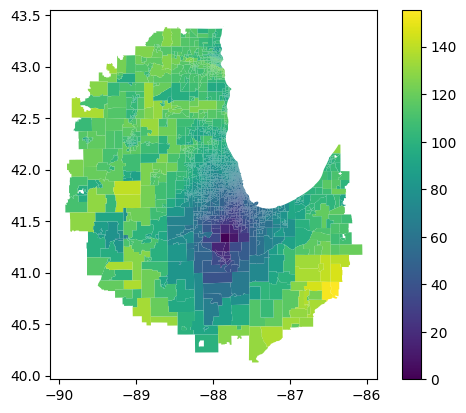

In [36]:
results.plot(column="minutes", legend=True)  # for debugging